In [119]:
!pip install pandas numpy scikit-learn torch

In [120]:
# check torch gpu
import torch

device = None

print("<!> Selecting GPU as main device <!>")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("<!> Using: " + torch.cuda.get_device_name(0) + "<!>")
else:
    print("<!> No GPU available <!>")
    exit(0)

<!> Selecting GPU as main device <!>
<!> Using: NVIDIA GeForce GTX 1050<!>


In [121]:
import pandas as pd

print("<!> Loading train dataframe <!>")
train_df = pd.read_csv('/root/test/train_transactions.csv')

<!> Loading train dataframe <!>


<!> Training <!>
Epoch 1, Loss: 0.0449
Epoch 2, Loss: 0.0217
Epoch 3, Loss: 0.0130
Epoch 4, Loss: 0.0132
Epoch 5, Loss: 0.0137
Epoch 6, Loss: 0.0132
Epoch 7, Loss: 0.0139
Epoch 8, Loss: 0.0131
Epoch 9, Loss: 0.0125
Epoch 10, Loss: 0.0128
Epoch 11, Loss: 0.0126
Epoch 12, Loss: 0.0127
Epoch 13, Loss: 0.0116
Epoch 14, Loss: 0.0067
Epoch 15, Loss: 0.0041
Epoch 16, Loss: 0.0032
Epoch 17, Loss: 0.0030
Epoch 18, Loss: 0.0027
Epoch 19, Loss: 0.0027
Epoch 20, Loss: 0.0025
Epoch 21, Loss: 0.0024
Epoch 22, Loss: 0.0026
Epoch 23, Loss: 0.0024
Epoch 24, Loss: 0.0026
Epoch 25, Loss: 0.0022
Epoch 26, Loss: 0.0022
Epoch 27, Loss: 0.0021
Epoch 28, Loss: 0.0025
Epoch 29, Loss: 0.0021
Epoch 30, Loss: 0.0024
Epoch 31, Loss: 0.0022
Epoch 32, Loss: 0.0023
Epoch 33, Loss: 0.0021
Epoch 34, Loss: 0.0022
Epoch 35, Loss: 0.0020
Epoch 36, Loss: 0.0021
Epoch 37, Loss: 0.0022
Epoch 38, Loss: 0.0021
Epoch 39, Loss: 0.0025
Epoch 40, Loss: 0.0021
Epoch 41, Loss: 0.0022
Epoch 42, Loss: 0.0031
Epoch 43, Loss: 0.0020
Epo

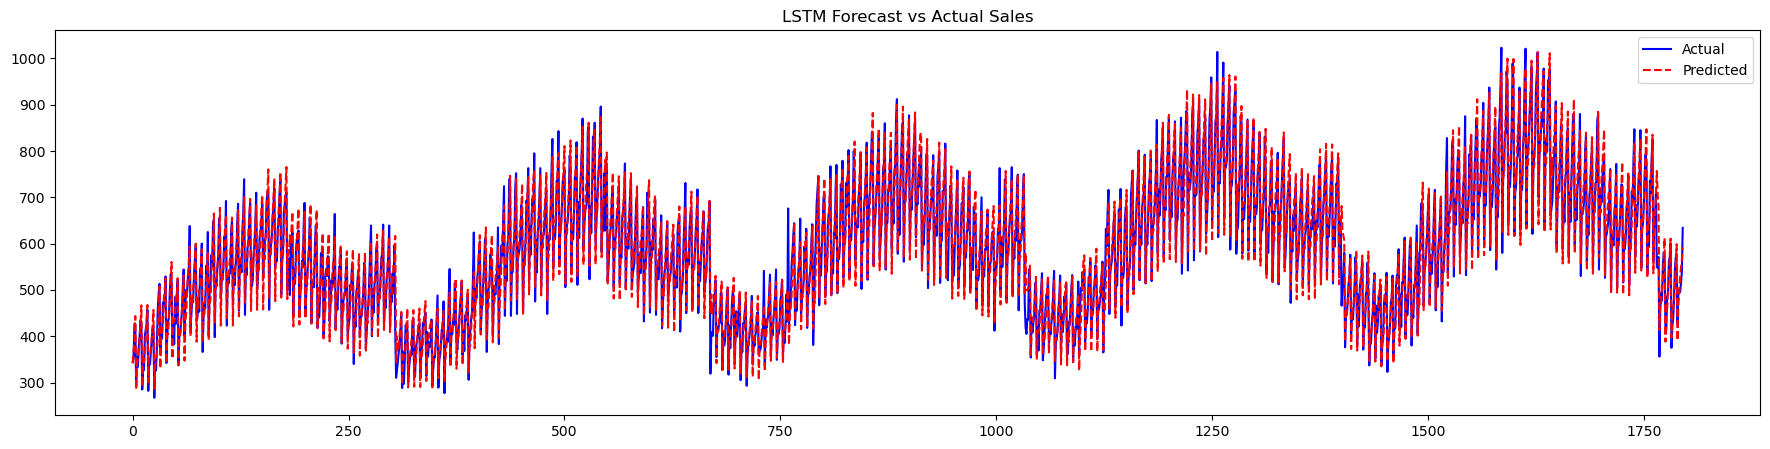

        ds    y_actual  yhat_forecast      error  error_percentage
0        0  344.000000     341.553925   2.446075          0.711068
1        1  355.000000     368.966705 -13.966705         -3.934283
2        2  427.000000     390.641998  36.358002          8.514754
3        3  426.000000     443.429382 -17.429382         -4.091404
4        4  293.000000     284.796753   8.203247          2.799743
...    ...         ...            ...        ...               ...
1791  1791  500.000031     494.202789   5.797241          1.159448
1792  1792  495.000000     528.499084 -33.499084         -6.767492
1793  1793  515.000000     547.663086 -32.663086         -6.342347
1794  1794  538.000000     564.331421 -26.331421         -4.894316
1795  1795  634.000000     592.471252  41.528748          6.550275

[1796 rows x 5 columns]
Mean Error Percentage: -0.59%


In [122]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from math import sqrt

# Function to create sequences
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Extract demand for product 2
train_series = train_df[str(2)].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
train_series = scaler.fit_transform(train_series)

# Generate sequences
SEQ_LENGTH = 30 
X_train, y_train = create_sequences(train_series, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)

# Create Dataset class
class DemandDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DemandDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define BiLSTM Model
class BiLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(BiLSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size * 2, 64)  # Bidirectional => hidden_size * 2
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        last_step_output = lstm_out[:, -1, :]  # Take last time step
        x = self.fc1(last_step_output)
        x = self.relu(x)
        return self.fc2(x)  # Final output layer

# Model setup
INPUT_SIZE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.2

model = BiLSTMPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50

# Training function
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

print("<!> Training <!>")
train_model()
print("<!> Done <!>")

# Save model
torch.save(model.state_dict(), "/root/test/lstm_trained_data.pth")

# Load test dataset
test_df = pd.read_csv('/root/test/test_transactions.csv')
test_series = test_df[str(2)].values.reshape(-1, 1)

# Normalize test data using the same scaler
test_series = scaler.transform(test_series)

# Create test sequences
X_test, y_test = create_sequences(test_series, SEQ_LENGTH)

# Convert test data to PyTorch tensors
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

# Function for evaluation
def evaluate_forecast(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)

    print("\n=== Evaluation for LSTM Model ===")
    print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}")
    print(f"  - Symmetric MAPE (SMAPE): {smape:.2f}")
    print(f"  - Mean Squared Error (MSE): {mse:.2f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  - R² Score: {r2:.2f}")

# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.cpu().numpy())

# Evaluate the model
evaluate_forecast(y_test, y_pred)

# Plot results
plt.figure(figsize=(22, 5))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Forecast vs Actual Sales")
plt.show()

# Compare forecasted sales to actual sales
comparison = pd.DataFrame({"ds": range(len(y_test)), "y_actual": y_test.flatten(), "yhat_forecast": y_pred.flatten()})
comparison['error'] = comparison['y_actual'] - comparison['yhat_forecast']
comparison['error_percentage'] = (comparison['error'] / comparison['y_actual']) * 100
print(comparison)

# Calculate mean error percentage
mean_error_percentage = comparison['error_percentage'].mean()
print(f"Mean Error Percentage: {mean_error_percentage:.2f}%")